In [44]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


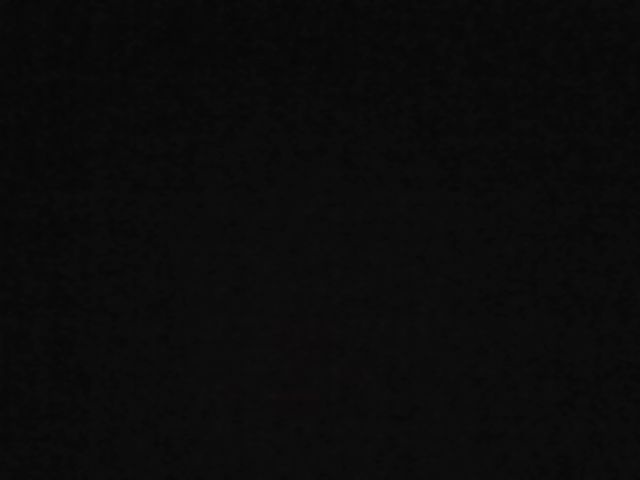

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
!pip install face_recognition

In [ ]:
!mkdir known
!wget https://e00-marca.uecdn.es/assets/multimedia/imagenes/2022/09/22/16638070009361.jpg -O known/LEBRON-JAMES.jpeg
!wget https://ntvb.tmsimg.com/assets/assets/1193060_v9_aa.jpg -O known/CONAN-GRAY.jpeg
!wget https://media1.popsugar-assets.com/files/thumbor/H55NTt0CjO6zP_EzMgaenh27VKQ/13x215:3516x3718/fit-in/2048xorig/filters:format_auto-!!-:strip_icc-!!-/2020/03/03/981/n/1922398/1c6ba0085e5edb2ca06156.71452790_/i/Emily-Blunt.jpg -O known/EMILY-BLUNT.jpeg

mkdir: cannot create directory ‘known’: File exists
--2026-01-22 19:35:14--  https://e00-marca.uecdn.es/assets/multimedia/imagenes/2022/09/22/16638070009361.jpg
Resolving e00-marca.uecdn.es (e00-marca.uecdn.es)... 3.171.100.126, 3.171.100.66, 3.171.100.124, ...
Connecting to e00-marca.uecdn.es (e00-marca.uecdn.es)|3.171.100.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131249 (128K) [image/jpeg]
Saving to: ‘known/LEBRON-JAMES.jpeg’

known/LEBRON-JAMES. 100%[===================>] 128.17K  --.-KB/s    in 0.003s  

2026-01-22 19:35:14 (39.7 MB/s) - ‘known/LEBRON-JAMES.jpeg’ saved [131249/131249]

--2026-01-22 19:35:14--  https://ntvb.tmsimg.com/assets/assets/1193060_v9_aa.jpg
Resolving ntvb.tmsimg.com (ntvb.tmsimg.com)... 13.249.95.90, 2600:9000:24f2:b800:3:aefa:ad1:7fc1, 2600:9000:24f2:2200:3:aefa:ad1:7fc1, ...
Connecting to ntvb.tmsimg.com (ntvb.tmsimg.com)|13.249.95.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468145 (457K

In [ ]:
!mkdir unknown
!wget https://www.usab.com/imgproxy/ziarB3UvXnVI_LC7nZ-bQGhvzCd55ihxL9jx7PNKzt4/rs:fit:3000:0:0/g:ce/q:90/aHR0cHM6Ly9zdG9yYWdlLmdvb2dsZWFwaXMuY29tL3VzYWItY29tLXByb2QvdXBsb2FkLzIwMjQvMDcvMDkvZGJkOTVjZWUtNDBlOS00MjBlLWEzZjAtMGI2M2Q3MDczMTk3LmpwZw.png -O unknown/1.jpeg
!wget https://static01.nyt.com/images/2022/06/28/arts/28CONAN-GRAY1/28CONAN-GRAY1-superJumbo.jpg -O unknown/2.jpeg
!wget https://m.media-amazon.com/images/M/MV5BMTUxNDY4MTMzM15BMl5BanBnXkFtZTcwMjg5NzM2Ng@@._V1_.jpg -O unknown/3.jpeg

mkdir: cannot create directory ‘unknown’: File exists
--2026-01-22 19:35:15--  https://www.usab.com/imgproxy/ziarB3UvXnVI_LC7nZ-bQGhvzCd55ihxL9jx7PNKzt4/rs:fit:3000:0:0/g:ce/q:90/aHR0cHM6Ly9zdG9yYWdlLmdvb2dsZWFwaXMuY29tL3VzYWItY29tLXByb2QvdXBsb2FkLzIwMjQvMDcvMDkvZGJkOTVjZWUtNDBlOS00MjBlLWEzZjAtMGI2M2Q3MDczMTk3LmpwZw.png
Resolving www.usab.com (www.usab.com)... 34.36.1.29
Connecting to www.usab.com (www.usab.com)|34.36.1.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 993911 (971K) [image/png]
Saving to: ‘unknown/1.jpeg’

unknown/1.jpeg      100%[===================>] 970.62K  --.-KB/s    in 0.007s  

2026-01-22 19:35:15 (143 MB/s) - ‘unknown/1.jpeg’ saved [993911/993911]

--2026-01-22 19:35:15--  https://static01.nyt.com/images/2022/06/28/arts/28CONAN-GRAY1/28CONAN-GRAY1-superJumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... c

In [ ]:
import face_recognition
import cv2
import os
from google.colab.patches import cv2_imshow

def read_img(path):
    img = cv2.imread(path)
    (h, w) = img.shape[:2]
    width = 500
    ratio = width / float(w)
    height = int(h * ratio)
    return cv2.resize(img, (width, height))

known_encodings = []
known_names = []
known_dir = 'known'

for file in os.listdir(known_dir):
    img = read_img(known_dir + '/' + file)
    img_enc = face_recognition.face_encodings(img)[0]
    known_encodings.append(img_enc)
    known_names.append(file.split('.')[0])

known_encodings

[array([-1.57134563e-01,  1.39682695e-01,  6.36185631e-02, -2.89229136e-02,
         3.59632149e-02, -9.19408947e-02,  6.43181205e-02, -2.38940250e-02,
         1.65483594e-01,  3.09829041e-03,  3.09999108e-01, -2.66301613e-02,
        -1.85269415e-01, -1.18317828e-01,  9.14820880e-02,  1.25487104e-01,
        -1.50242969e-01, -1.12594016e-01, -1.58495888e-01, -1.25662789e-01,
        -1.51392026e-02, -2.83403937e-02, -2.09582169e-02,  7.49483332e-02,
        -6.04832321e-02, -3.09471607e-01, -7.64638633e-02, -1.43904254e-01,
         4.97487001e-02, -1.18256420e-01,  4.66720052e-02,  1.84191540e-02,
        -2.27613539e-01, -8.72926712e-02, -8.38034675e-02,  1.52236307e-02,
         7.87342936e-02, -3.66858058e-02,  1.73675060e-01,  5.01952786e-03,
        -1.04875609e-01, -1.67469401e-02,  2.29891483e-02,  2.70308077e-01,
         1.88217193e-01, -8.84454772e-02,  3.18388231e-02,  3.41187418e-02,
         4.18747626e-02, -2.34719932e-01, -2.62264744e-04,  8.78222063e-02,
         1.6

Processing 2.jpeg


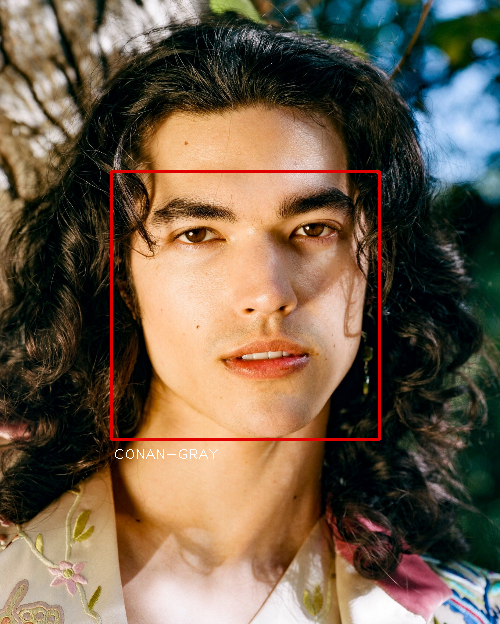

Processing 1.jpeg


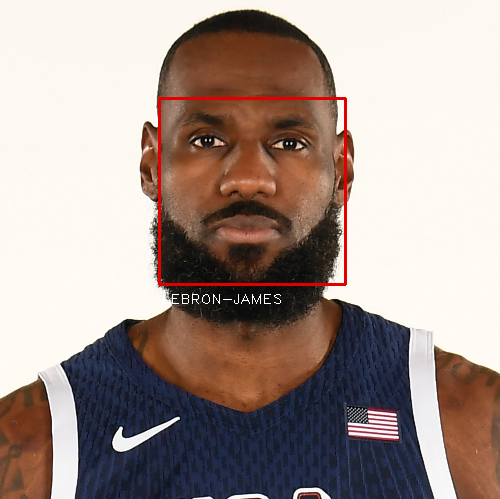

Processing 3.jpeg


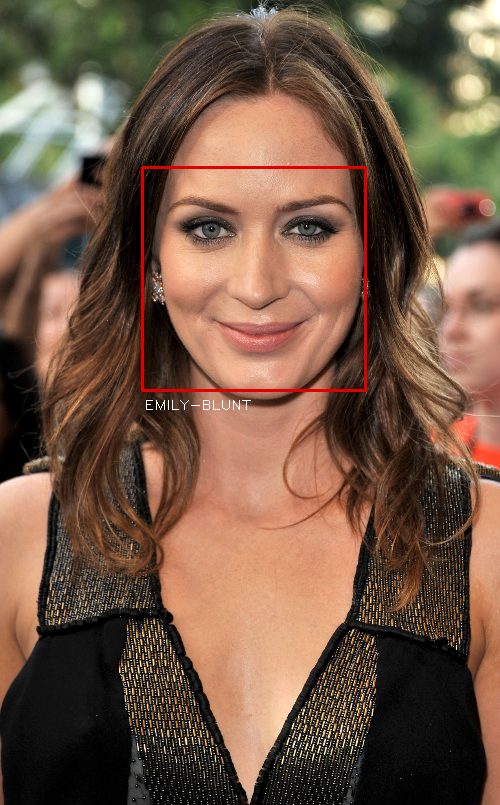

In [ ]:
unknown_dir = 'unknown'
for file in os.listdir(unknown_dir):
    print("Processing", file)
    img = read_img(unknown_dir + '/' + file)
    img_enc = face_recognition.face_encodings(img)[0]
    results = face_recognition.compare_faces(known_encodings, img_enc)

    for i in range(len(results)):
        if results[i]:
            name = known_names[i]
            (top, right, bottom, left) = face_recognition.face_locations(img)[0]
            cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 225), 2)
            cv2.putText(img, name, (left+2, bottom+20), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)
            cv2_imshow(img)